In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.dates import DateFormatter
import datetime
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
import os
os.chdir("/content/drive/MyDrive/projects/DailyElectricityPriceandDemandData/")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from models.model import Ridge_ss

In [2]:
config_model = "config/config_Ridge_ss.json"

conf = json.load(open("config/config.json"))
conf_model = json.load(open(config_model))
conf.update(conf_model)
all_params = [
    dict(zip(conf["cv_params"].keys(), v)) for v in itertools.product(*conf["cv_params"].values())
]
conf

{'cv_periods': [{'end': '2015-12-31', 'start': '2015-01-01'},
  {'end': '2016-12-31', 'start': '2016-01-01'},
  {'end': '2017-12-31', 'start': '2017-01-01'},
  {'end': '2018-12-31', 'start': '2018-01-01'}],
 'test_periods': {'train_start': '2015-01-01',
  'train_end': '2018-12-31',
  'test_start': '2019-01-01',
  'test_end': '2019-12-31'},
 'features': ['max_temperature',
  'holiday',
  'school_day',
  'dayofweek_cos',
  'dayofweek_sin',
  'month_cos',
  'month_sin'],
 'model': 'Ridge_ss',
 'cv_params': {'alpha': [0.01, 0.1, 1.0, 10], 'n_jobs': [-1]}}

In [3]:
all_params

[{'alpha': 0.01, 'n_jobs': -1},
 {'alpha': 0.1, 'n_jobs': -1},
 {'alpha': 1.0, 'n_jobs': -1},
 {'alpha': 10, 'n_jobs': -1}]

In [4]:
# 特徴量
df = pd.read_csv("data/complete_dataset.csv", index_col=0, parse_dates=True)
df = df.loc[:"2019-12-31"]
df.head()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [5]:
train_start = conf["test_periods"]["train_start"]
train_end = conf["test_periods"]["train_end"]
test_start = conf["test_periods"]["test_start"]
test_end = conf["test_periods"]["test_end"]

In [6]:
# なんか準備
bi_dic = {"Y":1, "N":0}
df["holiday"] = df["holiday"].map(bi_dic)
df["school_day"] = df["school_day"].map(bi_dic)
dow = pd.date_range(train_start, test_end).dayofweek + 1
df["dayofweek_cos"] = np.cos(2 * np.pi * dow / dow.max())
df["dayofweek_sin"] = np.sin(2 * np.pi * dow / dow.max())
month = pd.date_range(train_start, test_end).month
df["month_cos"] = np.cos(2 * np.pi * month / month.max())
df["month_sin"] = np.sin(2 * np.pi * month / month.max())

In [7]:
df_train = df.loc[train_start : train_end]
df_test = df.loc[test_start : test_end]

In [8]:
def walk_forward_validation(df_X, df_y , model, cutoffs):
  indexes = []
  y_vals = []
  y_preds =[]  
  for i in range(len(cutoffs)-1):
    train_start = cutoffs[i]["start"]
    train_end = cutoffs[i]["end"]
    val_start = cutoffs[i+1]["start"]
    val_end = cutoffs[i+1]["end"]

    X_train = df_X.loc[train_start : train_end]
    y_train = df_y.loc[train_start : train_end]
    X_val = df_X.loc[val_start : val_end]
    y_val = df_y.loc[val_start : val_end] 
    y_vals.extend(y_val)

    # モデルの学習
    model.fit(X_train, y_train)
    # 検証データの予測
    y_preds.extend(model.predict(X_val))
    indexes.extend(df_y.loc[val_start : val_end].index)

  df_cv = pd.DataFrame({"y" : y_vals, "y_pred" : y_preds}, index=indexes)
  return df_cv

In [9]:
len(all_params)

4

### 学習

In [10]:
maes = []
cutoff = conf["cv_periods"]
ex_col = conf["features"]

for params in all_params:
  df_y = df_train["demand"]
  f = df_train[ex_col]
  model = Ridge_ss(**params)
  df_cv = walk_forward_validation(f, df_y , model, cutoff)

  y_true = df_cv["y"]
  y_pred = df_cv["y_pred"]
  maes.append(mean_absolute_error(y_true, y_pred))

best_params = pd.DataFrame({"all_params" : all_params, "MAE" : maes}).sort_values("MAE").iloc[0].to_list()

In [11]:
best_params

[{'alpha': 0.01, 'n_jobs': -1}, 8048.878216240878]

### テストデータで精度見る

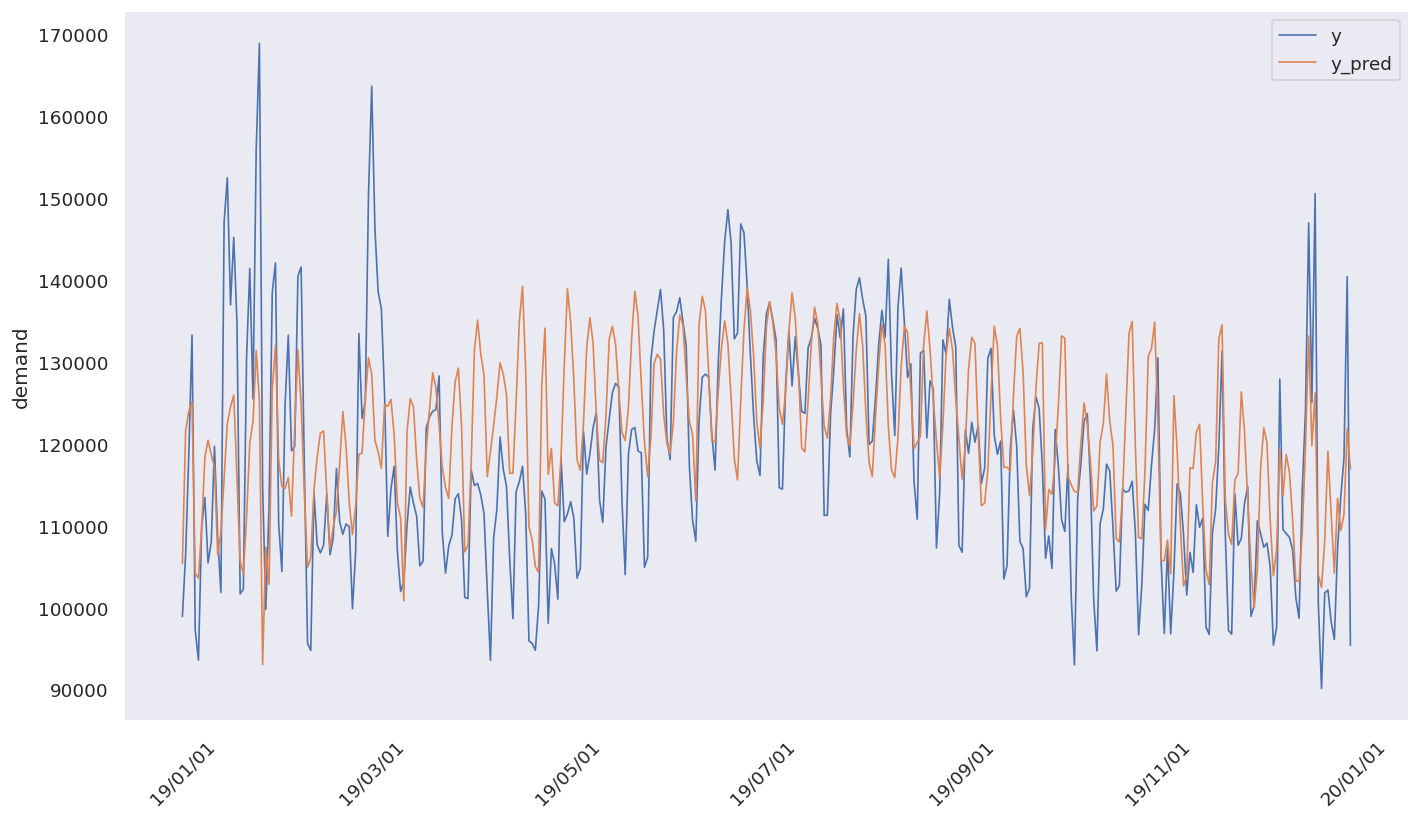

In [13]:
cutoffs = conf["test_periods"]

train_start = cutoffs["train_start"]
train_end = cutoffs["train_end"]
test_start = cutoffs["test_start"]
test_end = cutoffs["test_end"]

X = df_train.loc[train_start : train_end][ex_col]
y = df_train.loc[train_start : train_end]["demand"]
model = Ridge_ss(**best_params[0])
model.fit(X, y)
y_true = df_test.loc[test_start : test_end]["demand"]
X_test = df_test.loc[test_start : test_end][ex_col]
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_true, y_pred)
x = y_true.index

fig = plt.figure(figsize=(12, 7), dpi=120)
ax =fig.add_subplot(111)
ax.plot(x, y_true, linewidth=1.0, label="y")
ax.plot(x, y_pred, linewidth=1.0, label="y_pred")
ax.xaxis.set_major_formatter(DateFormatter("%y/%m/%d"))
#ax.set_title(f"MAE : {np.round(mae, 2)}")
ax.set_ylabel("demand")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

In [14]:
print(mae)

9036.934301369864


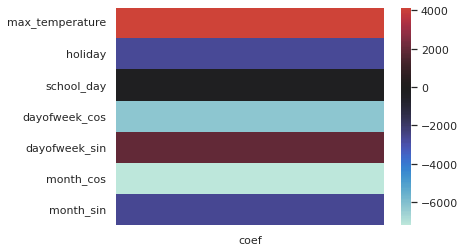

In [24]:
if "Ridge_ss" in conf["model"]:
  coef = model.model["transformedtargetregressor"].regressor_["ridge"].coef_.reshape(-1, 1)
  sns.heatmap(coef, xticklabels=["coef"], yticklabels=ex_col, center=0)

elif "RndomForest" in conf["model"]:
  fig = plt.figure(figsize=(12, 7), dpi=120)
  ax =fig.add_subplot(111)
  ax.bar(ex_col, model.feature_importances_, label='feature_importance')
  plt.tight_layout()
  plt.legend()
  plt.show()
  plt.close()